In [1]:
import matplotlib.pyplot as plt 
%matplotlib inline 
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline, interp1d
import warnings;warnings.filterwarnings('ignore')
from tqdm import tqdm
import astropy.units as u
from astropy.constants import G

plt.rc('font', family = 'serif')
plt.rc('axes', lw = 2); plt.rc('text',usetex = True)

### Cosmological parameters

In [2]:
OmegaM0 = 0.3175,
OmegaR0 = 8.2 * 10**(-5)## see overleaf
h = 0.6711
H0 = 100*h*u.km/u.s/u.Mpc
rhobarM = 3*H0**2 / (8*np.pi*G)
rhobarM_h2MsunMpc3 = (rhobarM.to(u.Msun/u.Mpc**3) / h**2).value

### Carry-over material from other notebook

In [3]:
df = pd.read_csv('./linear_pk.txt', delim_whitespace = True, header = None, skiprows = 7)
df.columns = ['k','Pk']
interpolator = interp1d(df.k,df.Pk)

In [4]:
def tophat_filter(k, R):
    wtilde = 3 * (k*R)**-3 * (np.sin(k*R) - (k*R) * np.cos(k*R))
    return wtilde

In [5]:
def mass_variance_integrand(k,R=8): 
    wtilde_squared = tophat_filter(k,R)**2 
    integrand = (1/(2*np.pi**2)) * interpolator(k) * wtilde_squared * k**2 
    return integrand 

k_i = 0 
k_f = 100
result = quad(mass_variance_integrand,k_i,k_f)
sigma8=np.sqrt(result[0])
print(f'{sigma8:.3f}')

0.834


In [6]:
growth_function_D = UnivariateSpline([0,0.5,1,2],[1, 0.76872625,0.60653086,0.41693915])

### Set up functions for main calculations + some helper functions

In [7]:
def convert_M_to_R(M):      
        R = (M / ((4/3 * np.pi * rhobarM_h2MsunMpc3)))**(1/3)
        return R

In [8]:
def convert_R_to_M(R):      
        M = (4/3) * rhobarM_h2MsunMpc3 * np.pi * R**3 
        return M

In [9]:
def mass_variance(M): 
    RList = convert_M_to_R(M)
    k_i = 0 
    k_f = 100
    sigmaM = np.asarray([np.sqrt(quad(mass_variance_integrand,k_i,k_f, args = (Rval))[0]) for Rval in RList])
    
    return sigmaM / sigma8

$$ f_{\rm PS} = \sqrt{\frac{2}{\pi}} \nu e^{-\nu^2/2} $$
with 
$$ \nu = \frac{\delta_c(z)}{\sigma(M)} $$
where 
$$ \delta_c(z) = \frac{1.686}{D(z)} $$ 

Lastly, 
$$ n(M) \equiv \frac{dN}{dM} =  \frac{1}{M} \frac{d N}{d \ \rm ln M} = \frac{\bar{\rho}}{M^2}f_{\rm PS}(\nu) \left|\frac{d \ \ln \nu}{d \ \ln M}\right| $$ 

where I will plot  $\frac{1}{M} \frac{d N}{d \ \rm ln M} = M n(M)$.


These relations were taken from Frank van den Bosch's lecture slides.

### Sanity Check: Plot the Mass Variance Function

595221865306515.1


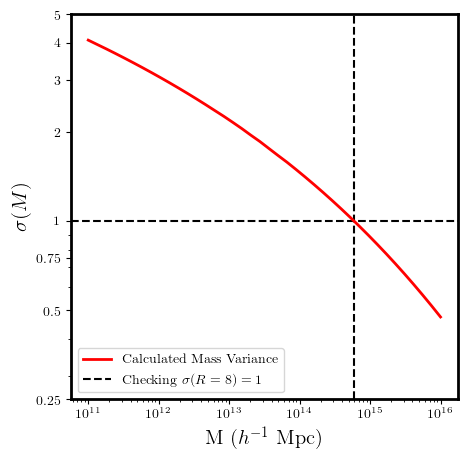

In [10]:
plt.figure(figsize = (5,5))
masslist = np.logspace(11,16,40)
mv = mass_variance(masslist)
plt.plot(masslist,mv, zorder = 2, color = 'red', lw = 2, label = 'Calculated Mass Variance')
plt.xscale('log'); plt.yscale('log')
plt.axvline(convert_R_to_M(8), color = 'black', ls = '--', zorder = -5)
plt.axhline(1, color = 'black', ls = '--', zorder = -5, label = 'Checking $\sigma(R=8) = 1$')
plt.xlabel('M ($h^{-1}$ Mpc)', fontsize = 15)
plt.ylabel('$\sigma(M)$', fontsize = 15)
plt.legend(loc = 'lower left')
_ = plt.gca().set_yticks([0.25,0.5,0.75,1,2,3,4,5])
_ = plt.gca().set_yticklabels([0.25,0.5,0.75,1,2,3,4,5])
print(convert_R_to_M(8))
plt.savefig('MassVariance.pdf',bbox_inches = 'tight')

In [11]:
def delta_c(z):
    return 1.686/growth_function_D(z) ## returns a scalar value

def nu(z,Mlist):
    return delta_c(z) / mass_variance(Mlist) ## returns a list 

def fps(z,Mlist):
    return np.sqrt(2/np.pi) * nu(z,Mlist) * np.exp(-0.5 * nu(z,Mlist)**2)

def mass_function(z,Mlist):

    logMasses = np.log(Mlist)
    log_nu_vals = np.log(nu(z,Mlist))
    nu_deriv = UnivariateSpline(np.log(Mlist),log_nu_vals).derivative()
    
    return rhobarM_h2MsunMpc3/Mlist**2 * fps(z,Mlist) * np.gradient(log_nu_vals, logMasses)  * Mlist

In [12]:
## Run Calculations
masslist = np.logspace(11,16,40) # higher number of masses tends to produce instability in derivative
nMz0 = mass_function(0,masslist)
nMz1 = mass_function(1,masslist)

In [13]:
## Load simulated dN/dM
simulated_z0 = pd.read_csv('./halo_z=0.txt', delim_whitespace = True)
simulated_z1 = pd.read_csv('./halo_z=1.txt', delim_whitespace = True)

In [14]:
counts_z0, edges_z0 = np.histogram(np.log10(simulated_z0['Mvir']), bins = 15); 
bin_centers_z0 = (edges_z0[1:] + edges_z0[:-1])/2 # get centers
dndlnM_z0 = counts_z0 * bin_centers_z0

counts_z1, edges_z1 = np.histogram(np.log10(simulated_z1['Mvir']), bins = 15); 
bin_centers_z1 = (edges_z1[1:] + edges_z1[:-1])/2 # get centers
dndlnM_z1 = counts_z1 * bin_centers_z1 

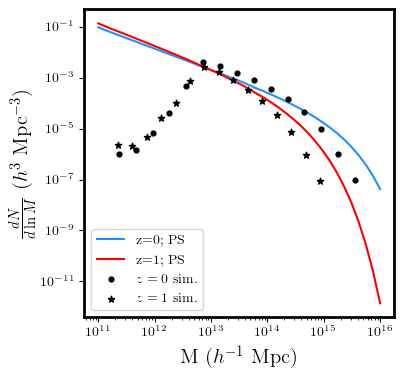

In [15]:
plt.figure(figsize = (4,4))
plt.plot(masslist,nMz0, label = 'z=0; PS', color = 'dodgerblue')
plt.plot(masslist,nMz1, label = 'z=1; PS', color = 'red')
plt.scatter(10**bin_centers_z0, dndlnM_z0/1e9, color = 'black', label = '$z=0$ sim.', s = 12, zorder = 5)
plt.scatter(10**bin_centers_z1, dndlnM_z1/1e9, color = 'black', label = '$z=1$ sim.', s = 22, 
            marker = '*',zorder = 3, edgecolor = 'black', facecolor = None)

plt.xscale('log'); plt.yscale('log')
plt.legend(loc = 'lower left')
plt.ylabel(r'$\frac{dN}{d \ln M} \ (h^{3} \ \rm Mpc^{-3})$', fontsize = 15)
plt.xlabel(r'M ($h^{-1}$ Mpc)', fontsize = 15)
plt.savefig('HMF.pdf',bbox_inches = 'tight')

In [25]:
mp = np.sum(np.sum(simulated_z0['Mvir']))/(1024)**3
print(mp/1e10)

1.8195011514611539


In [26]:
simulated_z0['Mvir'].min() / mp

9.018955545492192